# Прогнозирование продаж продуктов питания

Необходимо спрогнозировать продажи тысяч семейств товаров, продаваемых в магазинах Favorita, расположенных в Эквадоре. Данные обучения включают даты, информацию о магазине и продукте, информацию о том, продвигался ли этот товар, а также номера продаж. Дополнительные файлы содержат дополнительную информацию, которая может быть полезна при построении ваших моделей.


Метрикой оценки для этого конкурса является среднеквадратическая ошибка. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from statsmodels.tsa.seasonal import seasonal_decompose
import sktime
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split, TimeSeriesSplit 
from sktime.utils.plotting import plot_series
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
from lightgbm import LGBMRegressor

In [2]:
# загрузка данных
train = pd.read_csv("C:/Users/ven89/Downloads/store-sales-time-series-forecasting/train.csv", index_col=[0], parse_dates=['date'])
test = pd.read_csv("C:/Users/ven89/Downloads/store-sales-time-series-forecasting/test.csv", index_col=[0], parse_dates=['date'])
oil_df = pd.read_csv("C:/Users/ven89/Downloads/store-sales-time-series-forecasting/oil.csv", parse_dates=['date'])
holidays_events = pd.read_csv("C:/Users/ven89/Downloads/store-sales-time-series-forecasting/holidays_events.csv", parse_dates=['date'])
stores = pd.read_csv("C:/Users/ven89/Downloads/store-sales-time-series-forecasting/stores.csv")
transactions = pd.read_csv("C:/Users/ven89/Downloads/store-sales-time-series-forecasting/transactions.csv", parse_dates=['date'])

In [3]:
# функция для вывода общей информации
def start_data(df):
    display(df.sample(5))
    df.info()
    print()
    print('Описательная статистика')
    display(df.describe(include='all'))
    print('Количество пропущенных значений:', df.isna().sum().sum())
    print('Количество дубликатов:', df.duplicated().sum())

In [4]:
# обучающая выборка
start_data(train)

,date,store_nbr,family,sales,onpromotion
id,,,,,
2693419,2017-02-24,31,PERSONAL CARE,340.0,12
1320020,2015-01-13,46,LAWN AND GARDEN,11.0,0
2721255,2017-03-12,13,DELI,217.0,7
310244,2013-06-24,14,FROZEN FOODS,10.0,0
1148941,2014-10-08,46,GROCERY II,23.0,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   sales        float64       
 4   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 137.4+ MB

Описательная статистика


C:\Users\ven89\AppData\Local\Temp\ipykernel_14184\3282365114.py:7: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(df.describe(include='all'))


,date,store_nbr,family,sales,onpromotion
count,3000888,3.000888e+06,3000888,3.000888e+06,3.000888e+06
unique,1684,NaN,33,NaN,NaN
top,2013-01-01 00:00:00,NaN,AUTOMOTIVE,NaN,NaN
freq,1782,NaN,90936,NaN,NaN
first,2013-01-01 00:00:00,NaN,NaN,NaN,NaN
last,2017-08-15 00:00:00,NaN,NaN,NaN,NaN
mean,NaN,2.750000e+01,NaN,3.577757e+02,2.602770e+00
std,NaN,1.558579e+01,NaN,1.101998e+03,1.221888e+01
min,NaN,1.000000e+00,NaN,0.000000e+00,0.000000e+00
25%,NaN,1.400000e+01,NaN,0.000000e+00,0.000000e+00


Количество пропущенных значений: 0
Количество дубликатов: 0


In [5]:
# проверим, расположены ли данные в хронологическом порядке
print(train.index.is_monotonic)

True


In [6]:
# начало и конец обучающей выборки
print(train['date'].min())
print(train['date'].max())

2013-01-01 00:00:00
2017-08-15 00:00:00


В обучающей выборке выборке 3_000_888 строк и 6 столбцов:
- id - идентификатор
- date - дата
- store_nbr - идентифицирует магазин, в котором продаются товары.
- family- определяет тип продаваемого продукта.
- sales -  общий объем продаж семейства продуктов в конкретном магазине на определенную дату. Возможны дробные значения, поскольку продукция может продаваться в дробных единицах (например, 1,5 кг сыра, а не 1 пакетик чипсов).
- onpromotion - общее количество товаров в семействе продуктов, на которые были акции в магазине на определенную дату.

Пропущенных значений нет, данные расположены в хронолигическом порядке. Построим график распределения продаж по дням и в разрезе групп товаров.

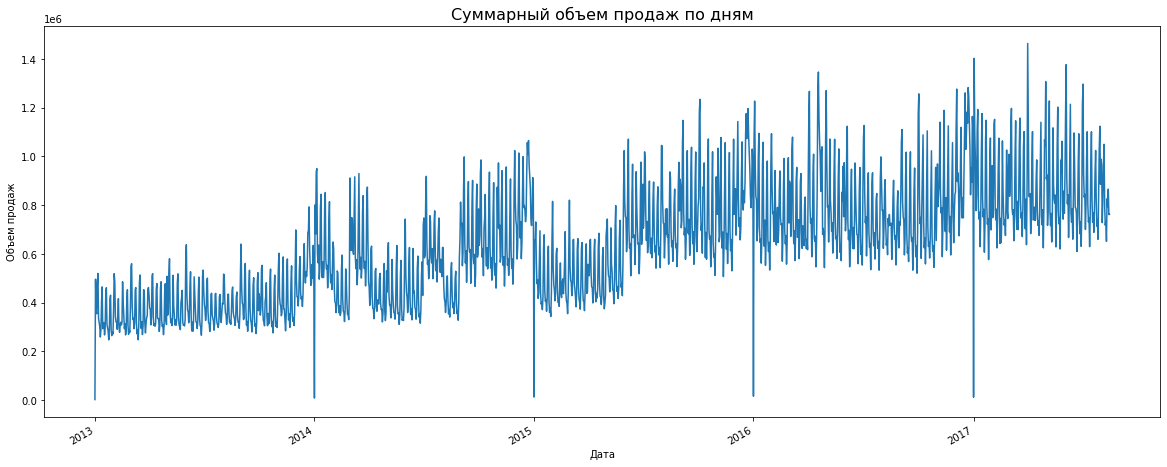

In [7]:
# построим график общих продаж по дням
plt.figure(figsize=(20,8))
plt.title('Суммарный объем продаж по дням', fontsize=16)
train.groupby('date')['sales'].sum().plot();
plt.xlabel('Дата')
plt.ylabel('Объем продаж');

Отметим, что нулевые продажи наблюдаются в Новый Год, так как магазины не работают. С 2013 год по 2017 наблюдается восходящий тренд. Разложим ряд на ьренд, сезонность и шум.

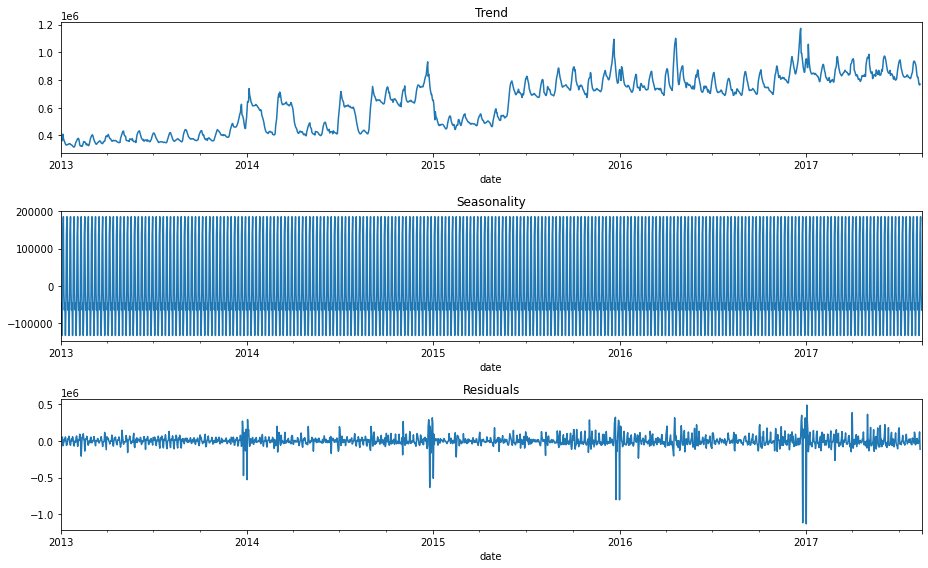

In [8]:
data=train[['date','sales']]
data.set_index('date', inplace=True)
df_seas = data['2013-01':'2017-08'].resample('1D').sum()
decomposed = seasonal_decompose(df_seas)

plt.figure(figsize=(13, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal .plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Тренд восходящий, для удобства посмотрим график сезонной в течении года и месяца.

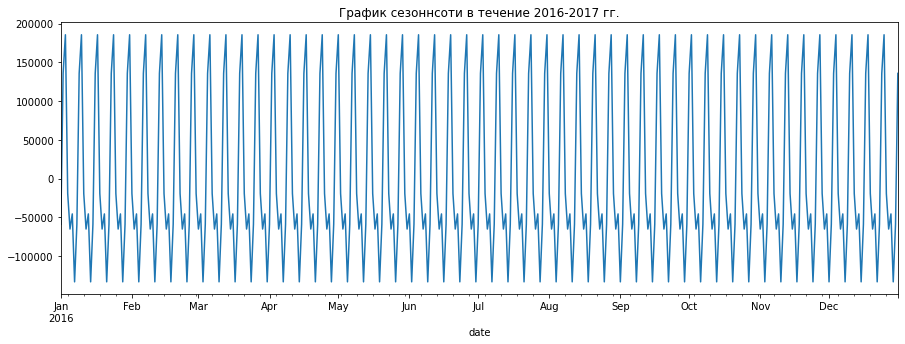

In [9]:
decomposed.seasonal['2016-01-01':'2016-12-31'].plot(figsize = (15,5));
plt.title('График сезоннсоти в течение 2016-2017 гг.');

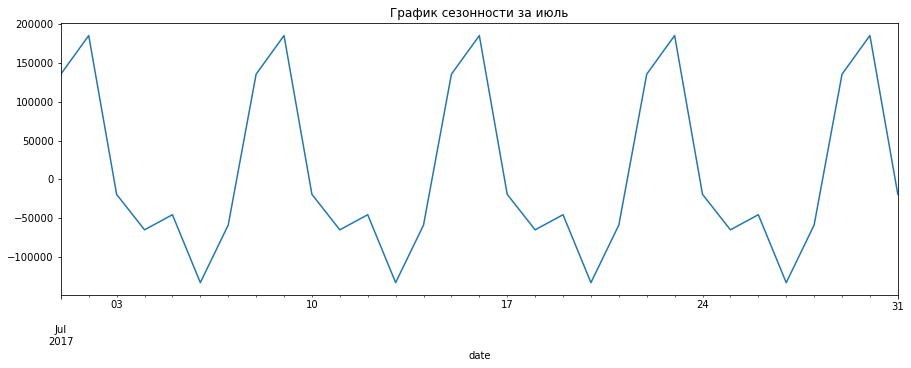

In [10]:
decomposed.seasonal['2017-07-01':'2017-07-31'].plot(figsize = (15,5));
plt.title('График сезонности за июль');

Наблюдается постоянная сезонность как в течение года, так в течение месяца. Наблюдается максимальное количество покупок в каждые 6-7 дней, что, скорее всего, связано с выходными, люди чаще всего покупают продукты в выходные и на всю неделю. Заработная плата в государственном секторе выплачивается каждые две недели – 15-го и в последний день месяца - это тоже влияет на продажи в супермаркетах.

In [11]:
# количество уникальных магазинов
train['store_nbr'].nunique()

54

In [12]:
# количество уникальных видов продукции
train['family'].nunique()

33

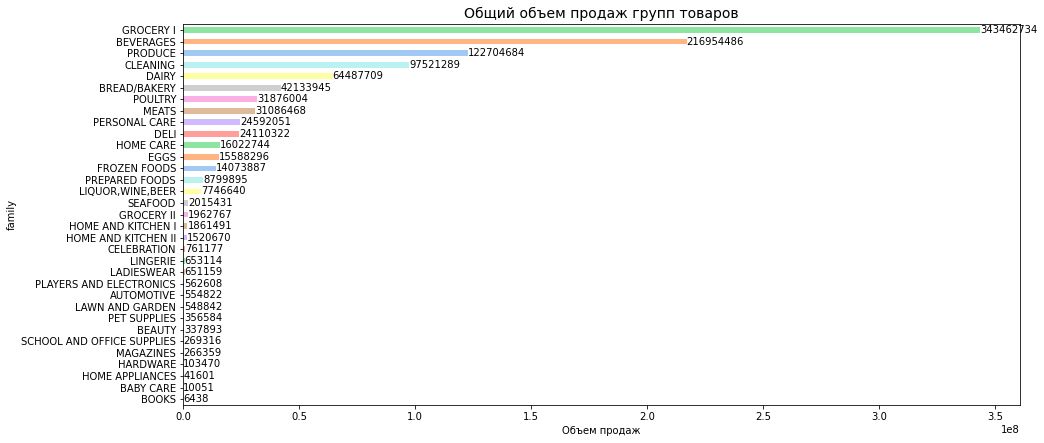

In [13]:
# график по суммарному объему продаж в зависимости от групп товаров
family_group = train.groupby('family')['sales'].sum().sort_values()

colors = sns.color_palette('pastel', len(family_group))

plt.figure(figsize=(15,7))
plt.title('Общий объем продаж групп товаров', fontsize=14)
plt.xlabel('Объем продаж')
plt.ylabel('группы товаров')
family_group.plot(kind='barh', color = colors);

for i, v in enumerate(family_group):
    plt.text(v + 10, i, str(int(v)), color='black', va='center', fontsize=10)

Больше всего объем продаж по бакалее, напиткам, продуктам что логично, продукты питания это товары первой необходимости. Самые редко покупаемые товары - это книги, уходобые товары для детей и бытовая техника. Книги неожиданно удивили, хотя, с учетом того, что сейчас все больше людей читают книги в электронном виде это, может быть, и не удивительно.

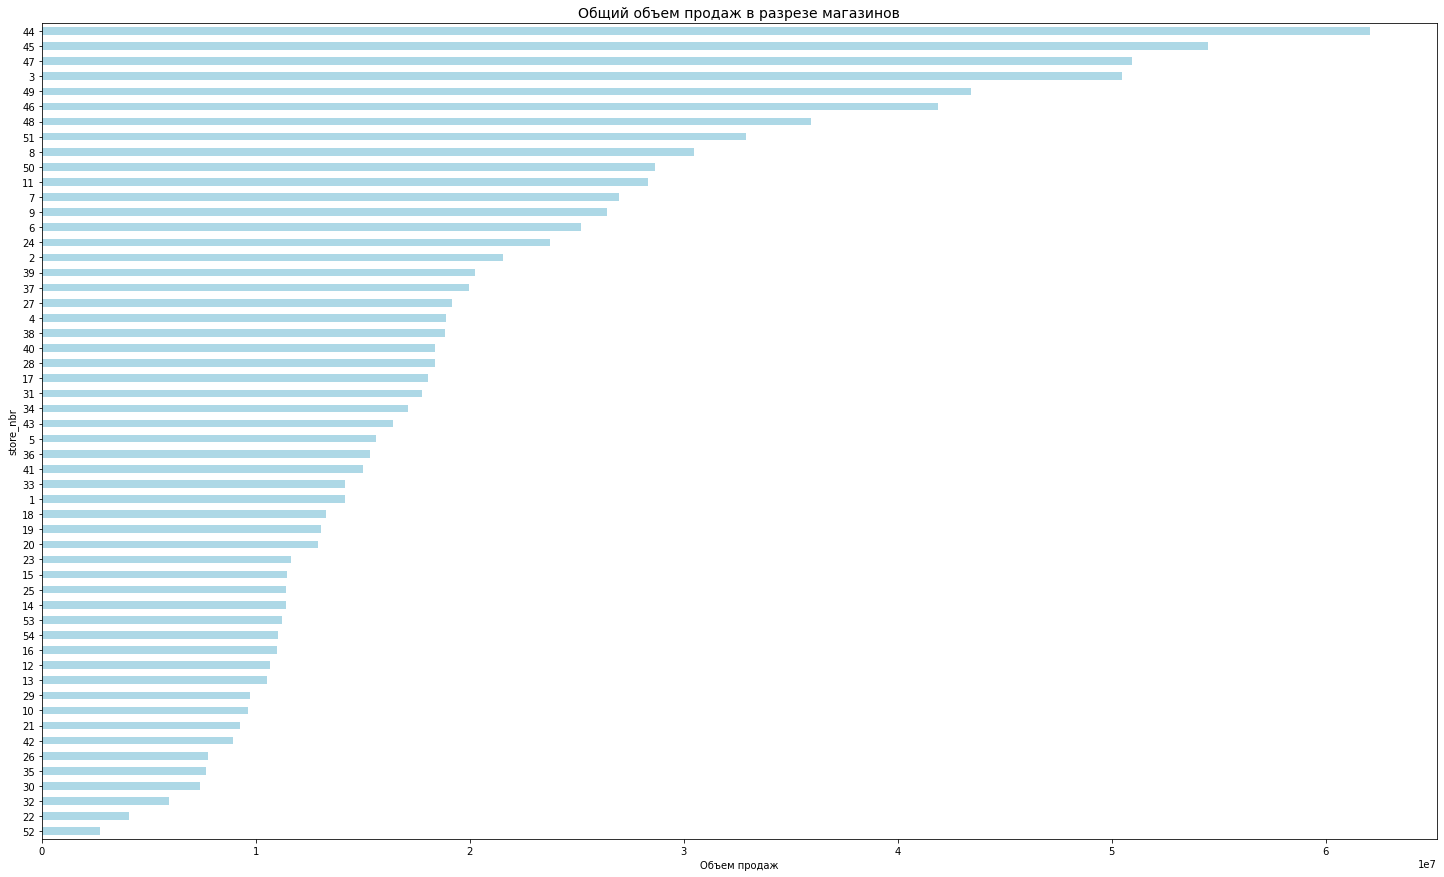

In [14]:
# график по суммарному объему продаж в зависимости от супермаркета
store_sales = train.groupby('store_nbr')['sales'].sum().sort_values()
plt.figure(figsize=(25,15))
plt.title('Общий объем продаж в разрезе магазинов', fontsize=14)
plt.xlabel('Объем продаж')
plt.ylabel('Магазин')
store_sales.plot(kind='barh', color='lightblue');

Больше всего продаж в супермаркете 44, 45, 47. Возможно, больше продаж связано с местонахождения супермаркета. Рассмотрим это более подробно далее.

In [15]:
# уникальные значения акций на товары
train['onpromotion'].unique()

array([  0,   3,   5,   1,  56,  20,  19,   2,   4,  18,  17,  12,   6,
         7,  10,   9,  50,   8,  16,  42,  51,  13,  15,  47,  21,  40,
        37,  54,  24,  58,  22,  59,  11,  45,  25,  55,  26,  43,  35,
        14,  28,  46,  36,  32,  53,  57,  27,  39,  41,  30,  29,  49,
        23,  48,  44,  38,  31,  52,  33,  34,  61,  60, 116,  86,  73,
       113, 102,  68, 104,  93,  70,  92, 121,  72, 178, 174, 161, 118,
       105, 172, 163, 167, 142, 154, 133, 180, 181, 173, 165, 168, 186,
       140, 149, 145, 169, 188,  62,  84, 111,  65, 107,  63, 101,  87,
       125,  94, 114, 171, 153, 170, 166, 141, 155, 179, 192, 131, 147,
       151, 189,  79,  74, 110,  64,  67,  99, 123, 157, 117, 150, 182,
       162, 160, 194, 135, 190,  69, 108,  89, 126, 156, 103, 146, 132,
       177, 164, 176, 112,  75, 109,  91, 128, 175, 187, 148, 137, 184,
       196, 144, 158, 119, 106,  66, 100,  90, 120, 115,  98, 159, 152,
       185, 139, 143,  80, 124,  71, 134, 193,  78,  88, 122, 13

In [16]:
# информация по тестовой выборке
start_data(test)

,date,store_nbr,family,onpromotion
id,,,,
3021404,2017-08-27,34,MAGAZINES,0
3017521,2017-08-25,26,BABY CARE,0
3021268,2017-08-27,30,LADIESWEAR,0
3020383,2017-08-26,6,PERSONAL CARE,13
3010560,2017-08-21,30,BEVERAGES,18


<class 'pandas.core.frame.DataFrame'>
Int64Index: 28512 entries, 3000888 to 3029399
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         28512 non-null  datetime64[ns]
 1   store_nbr    28512 non-null  int64         
 2   family       28512 non-null  object        
 3   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 1.1+ MB

Описательная статистика


C:\Users\ven89\AppData\Local\Temp\ipykernel_14184\3282365114.py:7: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(df.describe(include='all'))


,date,store_nbr,family,onpromotion
count,28512,28512.000000,28512,28512.000000
unique,16,NaN,33,NaN
top,2017-08-16 00:00:00,NaN,AUTOMOTIVE,NaN
freq,1782,NaN,864,NaN
first,2017-08-16 00:00:00,NaN,NaN,NaN
last,2017-08-31 00:00:00,NaN,NaN,NaN
mean,NaN,27.500000,NaN,6.965383
std,NaN,15.586057,NaN,20.683952
min,NaN,1.000000,NaN,0.000000
25%,NaN,14.000000,NaN,0.000000


Количество пропущенных значений: 0
Количество дубликатов: 0


In [17]:
print(test['date'].min())
print(test['date'].max())

2017-08-16 00:00:00
2017-08-31 00:00:00


In [18]:
test['store_nbr'].nunique()

54

Всего 28 тысяч значений с 16.08.2017 по 31.08.2017, столбцы те же, что и в обучабщей выборке. Пропущенных значений нет, дубликатов нет. Количество магазинов и количество групп товаров совпадает с обучающей выборкой.

In [19]:
# информация о цене на нефть
start_data(oil_df)

,date,dcoilwtico
442,2014-09-11,92.89
1072,2017-02-09,52.99
822,2016-02-25,31.40
1215,2017-08-29,46.46
1008,2016-11-11,43.39


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB

Описательная статистика


C:\Users\ven89\AppData\Local\Temp\ipykernel_14184\3282365114.py:7: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(df.describe(include='all'))


,date,dcoilwtico
count,1218,1175.000000
unique,1218,NaN
top,2013-01-01 00:00:00,NaN
freq,1,NaN
first,2013-01-01 00:00:00,NaN
last,2017-08-31 00:00:00,NaN
mean,NaN,67.714366
std,NaN,25.630476
min,NaN,26.190000
25%,NaN,46.405000


Количество пропущенных значений: 43
Количество дубликатов: 0


Наблюдаются пропущенные значения в цене нефти. Построим график.

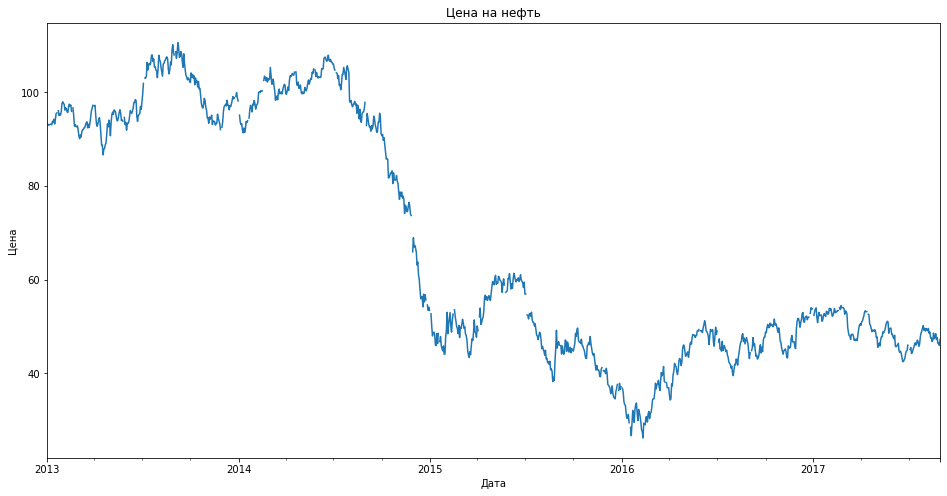

In [20]:
plt.figure(figsize=(16,8))
plt.title('Цена на нефть')
oil_df.groupby('date')['dcoilwtico'].mean().plot();
plt.xlabel('Дата')
plt.ylabel('Цена');

In [21]:
# пропущенные значения
oil_df[oil_df['dcoilwtico'].isna()]

,date,dcoilwtico
0,2013-01-01,NaN
14,2013-01-21,NaN
34,2013-02-18,NaN
63,2013-03-29,NaN
104,2013-05-27,NaN
132,2013-07-04,NaN
174,2013-09-02,NaN
237,2013-11-28,NaN
256,2013-12-25,NaN
261,2014-01-01,NaN


Пропущенные значения наблюдаются примернов одни и те же дни из года в год. Возможно это связано с праздниками. Пока не будем с ними ничего делать. После объединения таблиц вернемся к ним.

In [22]:
# информация о праздниках и выходных
start_data(holidays_events)

,date,type,locale,locale_name,description,transferred
21,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
118,2014-07-03,Holiday,Local,El Carmen,Cantonizacion de El Carmen,False
297,2017-01-01,Holiday,National,Ecuador,Primer dia del ano,True
62,2013-07-03,Holiday,Local,Santo Domingo,Fundacion de Santo Domingo,False
35,2012-12-24,Bridge,National,Ecuador,Puente Navidad,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB

Описательная статистика


C:\Users\ven89\AppData\Local\Temp\ipykernel_14184\3282365114.py:7: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(df.describe(include='all'))


,date,type,locale,locale_name,description,transferred
count,350,350,350,350,350,350
unique,312,6,3,24,103,2
top,2014-06-25 00:00:00,Holiday,National,Ecuador,Carnaval,False
freq,4,221,174,174,10,338
first,2012-03-02 00:00:00,NaN,NaN,NaN,NaN,NaN
last,2017-12-26 00:00:00,NaN,NaN,NaN,NaN,NaN


Количество пропущенных значений: 0
Количество дубликатов: 0


In [23]:
holidays_events['type'].value_counts()

Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: type, dtype: int64

In [24]:
holidays_events['locale'].value_counts()

National    174
Local       152
Regional     24
Name: locale, dtype: int64

In [25]:
holidays_events['locale_name'].unique()

array(['Manta', 'Cotopaxi', 'Cuenca', 'Libertad', 'Riobamba', 'Puyo',
       'Guaranda', 'Imbabura', 'Latacunga', 'Machala', 'Santo Domingo',
       'El Carmen', 'Cayambe', 'Esmeraldas', 'Ecuador', 'Ambato',
       'Ibarra', 'Quevedo', 'Santo Domingo de los Tsachilas',
       'Santa Elena', 'Quito', 'Loja', 'Salinas', 'Guayaquil'],
      dtype=object)

In [26]:
holidays_events['description'].nunique()

103

ПРИМЕЧАНИЕ. Обратите особое внимание на переносимый столбец. Перенесенный праздник официально приходится на этот календарный день, но был перенесен правительством на другую дату. Перенесенный день больше похож на обычный день, чем на праздник. Чтобы найти день, когда он действительно отмечался, найдите соответствующую строку, где тип — Перенос. Например, праздник Независимости Гуаякиля был перенесен с 09.10.2012 на 12.10.2012, что означает, что он отмечался 12.10.2012. Дни типа Bridge — это дополнительные дни, которые добавляются к празднику (например, чтобы продлить перерыв на длинные выходные). Они часто состоят из типа «Рабочий день», который представляет собой день, обычно не запланированный для работы (например, суббота), предназначенный для окупаемости Моста.
Дополнительные праздники — это дни, добавленные к обычному календарному празднику, например, как это обычно бывает перед Рождеством (сочельник становится праздником).
Дополнительные замечания


In [27]:
# информация о супермаркетах
start_data(stores)

,store_nbr,city,state,type,cluster
50,51,Guayaquil,Guayas,A,17
28,29,Guayaquil,Guayas,E,10
48,49,Quito,Pichincha,A,11
16,17,Quito,Pichincha,C,12
13,14,Riobamba,Chimborazo,C,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB

Описательная статистика


,store_nbr,city,state,type,cluster
count,54.000000,54,54,54,54.000000
unique,NaN,22,16,5,NaN
top,NaN,Quito,Pichincha,D,NaN
freq,NaN,18,19,18,NaN
mean,27.500000,NaN,NaN,NaN,8.481481
std,15.732133,NaN,NaN,NaN,4.693395
min,1.000000,NaN,NaN,NaN,1.000000
25%,14.250000,NaN,NaN,NaN,4.000000
50%,27.500000,NaN,NaN,NaN,8.500000
75%,40.750000,NaN,NaN,NaN,13.000000


Количество пропущенных значений: 0
Количество дубликатов: 0


In [28]:
stores['city'].value_counts()

Quito            18
Guayaquil         8
Cuenca            3
Santo Domingo     3
Manta             2
Latacunga         2
Machala           2
Ambato            2
Quevedo           1
Esmeraldas        1
Loja              1
Libertad          1
Playas            1
Daule             1
Babahoyo          1
Salinas           1
Puyo              1
Guaranda          1
Ibarra            1
Riobamba          1
Cayambe           1
El Carmen         1
Name: city, dtype: int64

Информация о городе , штате , типе и кластере, кластер — это группа похожих магазинов. Больше всего супермаркетов в городе Кито и Гуаякиль.

In [29]:
# информация по транзакциям. Одна покупка-одна транзакция
start_data(transactions)

,date,store_nbr,transactions
47098,2015-09-21,43,1350
37977,2015-03-23,54,821
29219,2014-09-21,25,663
25479,2014-07-04,16,874
65793,2016-09-13,51,1279


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB

Описательная статистика


C:\Users\ven89\AppData\Local\Temp\ipykernel_14184\3282365114.py:7: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(df.describe(include='all'))


,date,store_nbr,transactions
count,83488,83488.000000,83488.000000
unique,1682,NaN,NaN
top,2017-08-15 00:00:00,NaN,NaN
freq,54,NaN,NaN
first,2013-01-01 00:00:00,NaN,NaN
last,2017-08-15 00:00:00,NaN,NaN
mean,NaN,26.939237,1694.602158
std,NaN,15.608204,963.286644
min,NaN,1.000000,5.000000
25%,NaN,13.000000,1046.000000


Количество пропущенных значений: 0
Количество дубликатов: 0


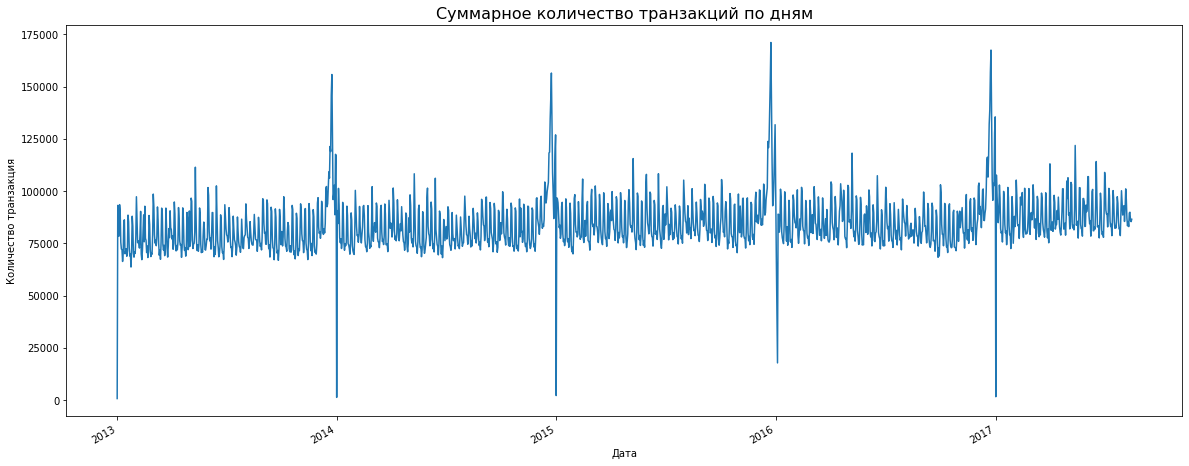

In [30]:
# построим график по транзакциям по дням
plt.figure(figsize=(20,8))
plt.title('Суммарное количество транзакций по дням', fontsize=16)
transactions.groupby('date')['transactions'].sum().plot();
plt.xlabel('Дата')
plt.ylabel('Количество транзакция');

График по транзакциям выглядит практически как график по суммарному объему продаж, что и логично. Считаю, что эти данные нам не нужны, так как чем больше объем продаж, тем больше транзакций. Данные могут сильно коррелировать между собой

## Объединение таблиц, предобработка и разведочный анализ данных

In [31]:
# объединяем в один датафрейм обучающую выборку
train_df = train.merge(oil_df, on='date', how='left').merge(right=holidays_events,on="date",how="left").merge(right=stores,on="store_nbr",how="left")

In [32]:
start_data(train_df)

,date,store_nbr,family,sales,onpromotion,dcoilwtico,type_x,locale,locale_name,description,transferred,city,state,type_y,cluster
1929547,2015-12-07,49,BOOKS,0.000,0,37.64,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,A,11
990341,2014-07-03,28,BREAD/BAKERY,464.000,0,104.76,Holiday,Local,Santo Domingo,Fundacion de Santo Domingo,False,Guayaquil,Guayas,E,10
1047767,2014-08-03,8,HOME APPLIANCES,1.000,0,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,8
697920,2014-01-23,41,BEVERAGES,1151.000,0,97.23,NaN,NaN,NaN,NaN,NaN,Machala,El Oro,D,4
606271,2013-12-03,2,POULTRY,500.593,0,95.83,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054348 entries, 0 to 3054347
Data columns (total 15 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   sales        float64       
 4   onpromotion  int64         
 5   dcoilwtico   float64       
 6   type_x       object        
 7   locale       object        
 8   locale_name  object        
 9   description  object        
 10  transferred  object        
 11  city         object        
 12  state        object        
 13  type_y       object        
 14  cluster      int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(9)
memory usage: 372.8+ MB

Описательная статистика


C:\Users\ven89\AppData\Local\Temp\ipykernel_14184\3282365114.py:7: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(df.describe(include='all'))


,date,store_nbr,family,sales,onpromotion,dcoilwtico,type_x,locale,locale_name,description,transferred,city,state,type_y,cluster
count,3054348,3.054348e+06,3054348,3.054348e+06,3.054348e+06,2.099196e+06,502524,502524,502524,502524,502524,3054348,3054348,3054348,3.054348e+06
unique,1684,NaN,33,NaN,NaN,NaN,6,3,24,101,2,22,16,5,NaN
top,2014-06-25 00:00:00,NaN,AUTOMOTIVE,NaN,NaN,NaN,Holiday,National,Ecuador,Carnaval,False,Quito,Pichincha,D,NaN
freq,7128,NaN,92556,NaN,NaN,NaN,304722,261954,261954,17820,486486,1018116,1074678,1018116,NaN
first,2013-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2017-08-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.750000e+01,NaN,3.590209e+02,2.617480e+00,6.801587e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.481481e+00
std,NaN,1.558579e+01,NaN,1.107286e+03,1.225494e+01,2.569134e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.649735e+00
min,NaN,1.000000e+00,NaN,0.000000e+00,0.000000e+00,2.619000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00
25%,NaN,1.400000e+01,NaN,0.000000e+00,0.000000e+00,4.641000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000e+00


Количество пропущенных значений: 13714272
Количество дубликатов: 0


In [33]:
train_df.isna().sum()

date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
dcoilwtico      955152
type_x         2551824
locale         2551824
locale_name    2551824
description    2551824
transferred    2551824
city                 0
state                0
type_y               0
cluster              0
dtype: int64

In [34]:
# переименуем некоторые столбцы
train_df = train_df.rename(columns = {'type_x': 'type_events', 'type_y': 'type_locale'})

Наблюдаются пропущенные значения в цене на нефть, пока заменим их на ноль и всей информации по праздникам. Заменим информацию по праздникам на Work day, так как если это не праздник-это рабочий день.

In [35]:
train_df['dcoilwtico'] = train_df['dcoilwtico'].fillna(0)

In [36]:
train_df = train_df.fillna('Work day')

In [37]:
train_df.isna().sum().sum()

0

In [38]:
train_df.sample(5)

,date,store_nbr,family,sales,onpromotion,dcoilwtico,type_events,locale,locale_name,description,transferred,city,state,type_locale,cluster
2596163,2016-12-05,52,LAWN AND GARDEN,0.000,0,51.72,Additional,Local,Quito,Fundacion de Quito-1,False,Manta,Manabi,A,11
176335,2013-04-09,7,HOME AND KITCHEN II,0.000,0,94.18,Work day,Work day,Work day,Work day,Work day,Quito,Pichincha,D,8
1029159,2014-07-24,35,LINGERIE,1.000,0,102.76,Additional,Local,Guayaquil,Fundacion de Guayaquil-1,False,Playas,Guayas,C,3
1223221,2014-11-10,30,EGGS,91.000,0,77.43,Holiday,Local,Guaranda,Independencia de Guaranda,False,Guayaquil,Guayas,C,3
2520734,2016-10-25,36,PREPARED FOODS,68.513,0,49.45,Work day,Work day,Work day,Work day,Work day,Libertad,Guayas,E,10


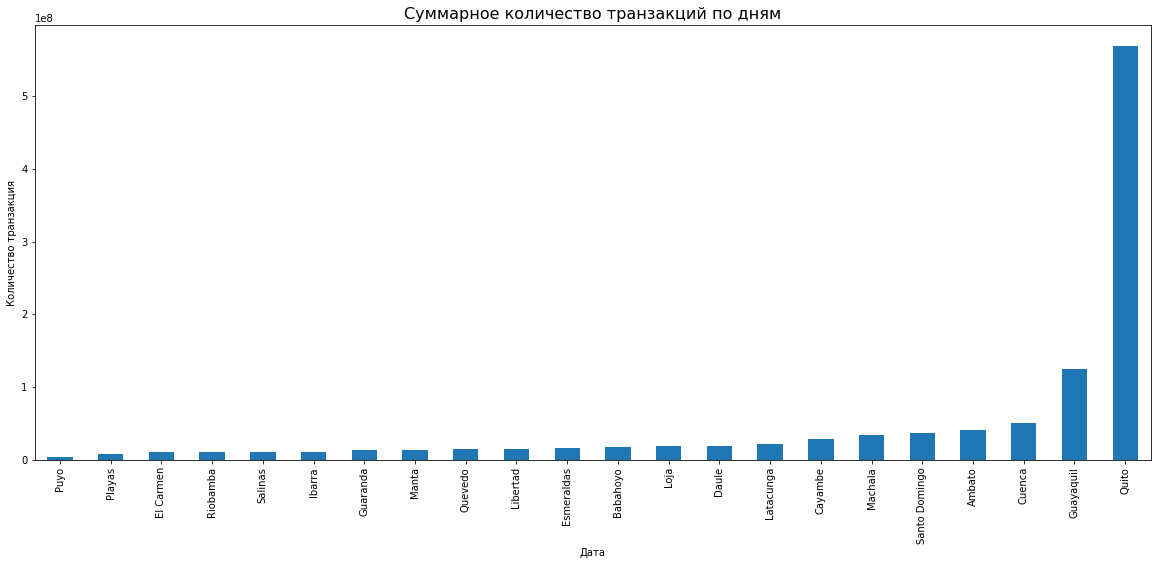

In [39]:
# построим график по транзакциям по дням
plt.figure(figsize=(20,8))
plt.title('Суммарное количество транзакций по дням', fontsize=16)
train_df.groupby('city')['sales'].sum().sort_values().plot(kind='bar');
plt.xlabel('Дата')
plt.ylabel('Количество транзакция');

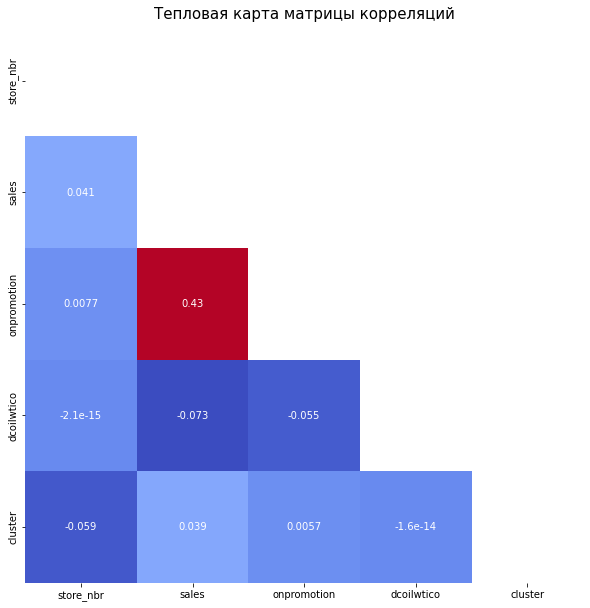

In [40]:
# посмотрим корреляцию между признаками
plt.figure(figsize=(10, 15))
matrix = np.triu(train_df.corr())
heatmap = sns.heatmap(train_df.corr(),
                      annot=True,
                      mask=matrix,
                      square=True,
                      cmap='coolwarm',
                      cbar=False,
                      fmt='.2g')
heatmap.set_title('Тепловая карта матрицы корреляций', fontsize=15);

In [41]:
# функция признаков
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data['day_of_week'] = data['date'].dt.dayofweek
    data['day_of_year'] = data['date'].dt.dayofyear
    data["season"] = np.where(data.date.dt.month.isin([12,1,2]), 0, 1)
    data["season"] = np.where(data.date.dt.month.isin([3,4,5]), 1, data["season"])
    data["season"] = np.where(data.date.dt.month.isin([6,7,8]), 2, data["season"])
    data["season"] = np.where(data.date.dt.month.isin([9, 10, 11]), 3, data["season"])
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['sales'].shift(lag)

    data['rolling_mean'] = data['sales'].shift().rolling(rolling_mean_size).mean()
    data = data.dropna()


In [42]:
make_features(train_df, 24, 100)

In [43]:
# удалим пустые значения
train_df = train_df.dropna()
train_df.head()

,date,store_nbr,family,sales,onpromotion,dcoilwtico,type_events,locale,locale_name,description,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
100,2013-01-01,12,BABY CARE,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,2013-01-01,12,BEAUTY,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,2013-01-01,12,BEVERAGES,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,2013-01-01,12,BOOKS,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104,2013-01-01,12,BREAD/BAKERY,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Подготовка к обучению

In [44]:
#  делим на фичи и таргет
X = train_df.drop(columns=['sales', 'date'], axis=1)
y = train_df[['sales']]

In [45]:
# проверка
X.shape, y.shape

((3054248, 44), (3054248, 1))

In [46]:
X_train, X_test, y_train , y_test = temporal_train_test_split(X, y, test_size=15000)

Так как мы работаем с временным рядом, нельзя применять кросс-валидацию в привычном виде для подбора гиперпараметров моделей с помощью GridSearchCV. Поэтому применим функцию TimeSeriesSplit().

In [47]:
tscv = TimeSeriesSplit(n_splits=5)

### LightGBM

In [48]:
# составим список категориальных признаков
cat_features = list(X_train.select_dtypes(include=['object']).columns)
cat_features

['family',
 'type_events',
 'locale',
 'locale_name',
 'description',
 'transferred',
 'city',
 'state',
 'type_locale']

In [49]:
X_train_gbm = X_train.copy()
X_test_gbm = X_test.copy()
for cat in cat_features:
    X_train_gbm[cat] = X_train_gbm[cat].astype('category')
    X_test_gbm[cat] = X_test_gbm[cat].astype('category')
X_train_gbm.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3039248 entries, 100 to 3039347
Data columns (total 44 columns):
 #   Column        Dtype   
---  ------        -----   
 0   store_nbr     int64   
 1   family        category
 2   onpromotion   int64   
 3   dcoilwtico    float64 
 4   type_events   category
 5   locale        category
 6   locale_name   category
 7   description   category
 8   transferred   category
 9   city          category
 10  state         category
 11  type_locale   category
 12  cluster       int64   
 13  year          int64   
 14  month         int64   
 15  day           int64   
 16  day_of_week   int64   
 17  day_of_year   int64   
 18  season        int32   
 19  lag_1         float64 
 20  lag_2         float64 
 21  lag_3         float64 
 22  lag_4         float64 
 23  lag_5         float64 
 24  lag_6         float64 
 25  lag_7         float64 
 26  lag_8         float64 
 27  lag_9         float64 
 28  lag_10        float64 
 29  lag_11      

In [50]:
# подбор гиперпараметров
model_gmb = lgb.LGBMRegressor(objective='regression', 
                        random_state=42)
params_gmb = {
      'learning_rate': [0.1, 0.25],
      #'n_estimators': [50, 100, 150],
      'n_estimators': [50, 100],
      'max_depth': [5, 7, 10],
      #'colsample_bytree': [0.7, 0.8, 0.9],
      #'subsample': [0.7, 0.8, 0.9],
      #'min_child_samples': [1, 5, 10]
  }
grid_cv_gmb = GridSearchCV(estimator=model_gmb, 
                       param_grid=params_gmb,
                       cv=tscv, 
                       n_jobs=-1, 
                       scoring='neg_root_mean_squared_error')
#grid_cv_gmb.fit(train_features_gbm, train_target)
grid_cv_gmb.fit(X_train_gbm, y_train, categorical_feature = cat_features)
rmse_cv_gmb = (grid_cv_gmb.best_score_)
print('Best hyperparams: ', grid_cv_gmb.best_params_)
#print('RMSE score on train sample: {:.2f}'.format((-grid_cv_gmb.best_score_) ** 0.5))

C:\Users\ven89\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Best hyperparams:  {'learning_rate': 0.25, 'max_depth': 7, 'n_estimators': 100}


In [51]:
rmse_gr_gbm = abs(grid_cv_gmb.best_score_)
rmse_gr_gbm

317.41561683238257

In [52]:
# обучение модели
%time

model_lgb = LGBMRegressor(random_state=42, max_depth=7, n_estimators=100, learning_rate=0.25)
model_lgb.fit(X_train_gbm, y_train, 
              eval_set=(X_test_gbm, y_test), 
              verbose=10, 
              eval_metric='rmse')


CPU times: total: 0 ns
Wall time: 3 ms


C:\Users\ven89\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ven89\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ven89\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[10]	valid_0's rmse: 284.747	valid_0's l2: 81080.7
[20]	valid_0's rmse: 259.156	valid_0's l2: 67161.8
[30]	valid_0's rmse: 255.342	valid_0's l2: 65199.3
[40]	valid_0's rmse: 246.805	valid_0's l2: 60912.8
[50]	valid_0's rmse: 241.747	valid_0's l2: 58441.4
[60]	valid_0's rmse: 239.292	valid_0's l2: 57260.8
[70]	valid_0's rmse: 234.546	valid_0's l2: 55012.1
[80]	valid_0's rmse: 232.469	valid_0's l2: 54042
[90]	valid_0's rmse: 230.72	valid_0's l2: 53231.6
[100]	valid_0's rmse: 229.016	valid_0's l2: 52448.5


LGBMRegressor(learning_rate=0.25, max_depth=7, random_state=42)

In [53]:
# предсказание модели

pred_gbmp = model_lgb.predict(X_test_gbm)
rmse_gbm = mean_squared_error(y_test, pred_gbmp) ** 0.5

print(f'RMSE модели на базе библиотеки LGBM {round(rmse_gbm, 4)}')

RMSE модели на базе библиотеки LGBM 229.0164


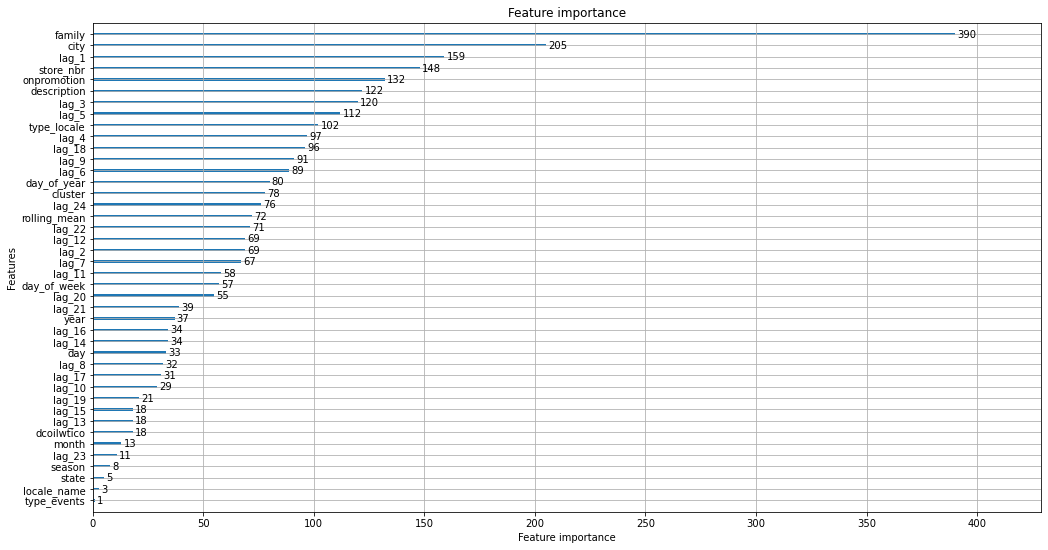

In [54]:
# важность параметров
lgb.plot_importance(model_lgb, figsize = (17, 9))
plt.show()

Самый важный признак для объема продаж имеет тип товаров, город и lag1.